# Baseline Model

---

## Imports

In [33]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import f1_score, classification_report, confusion_matrix, multilabel_confusion_matrix
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel
from transformers import logging
from tqdm import tqdm

In [2]:
logging.set_verbosity_error()

In [3]:
MAX_SEQUENCE_LENGTH = 200

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

---

## Data Loading

In [5]:
dataset = pd.read_parquet("../data/clean_data.parquet")

---

## Data Pre-processing 

Load the bert model

In [6]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
bert_model = TFBertModel.from_pretrained("bert-base-cased")

In [7]:
processed = dict()
for group in tqdm(["train", "validation", "test"]):
    df = dataset.loc[lambda f: f["set"] == group].pivot_table(
        index=["code", "text"],
        columns=["goemotion"],
        values="set",
        aggfunc="count",
        fill_value=0
    ).reset_index()

    processed[group] = dict()
    processed[group]["tokens"] = bert_tokenizer(
        df.text.to_list(), max_length=MAX_SEQUENCE_LENGTH, truncation=True, padding="max_length", return_tensors="tf"
    )
    processed[group]["inputs"] = [
        processed[group]["tokens"].input_ids, 
        processed[group]["tokens"].token_type_ids, 
        processed[group]["tokens"].attention_mask
    ]
    processed[group]["labels"] = df.iloc[:, 2:].values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.71s/it]


---

## Model Training 

In [20]:
def create_bert_cls_model(
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=128, 
    dropout=0.3,
    learning_rate=0.00002,
    epsilon=1e-07
):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """
    bert_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name="input_ids_layer")
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name="token_type_ids_layer")
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name="attention_mask_layer")

    bert_inputs = {"input_ids": input_ids, "token_type_ids": token_type_ids, "attention_mask": attention_mask}      
    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation="relu", name="hidden_layer")(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(28, activation="softmax", name="classification_layer")(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon),
      loss=tf.keras.losses.CategoricalCrossentropy(), 
      metrics="accuracy"
    )
    
    return classification_model

In [21]:
bert_cls_model = create_bert_cls_model()                                                      
bert_model_history = bert_cls_model.fit(
    processed["train"]["inputs"],
    processed["train"]["labels"],
    validation_data=(processed["validation"]["inputs"], processed["validation"]["labels"]),
    batch_size=16,
    epochs=2
)

Epoch 1/2
2714/2714 [==============================] - 705s 255ms/step - loss: 2.1658 - accuracy: 0.5677 - val_loss: 2.2407 - val_accuracy: 0.5682
Epoch 2/2
2714/2714 [==============================] - 686s 253ms/step - loss: 2.4011 - accuracy: 0.6222 - val_loss: 3.1608 - val_accuracy: 0.5590


## Model Prediction 

In [76]:
val_pred = bert_cls_model.predict(processed["validation"]["inputs"])
test_pred  = bert_cls_model.predict(processed["test"]["inputs"])

170/170 [==============================] - 2400s 14s/step


In [77]:
v = list()
for t in tqdm(np.linspace(0.01, 0.99, 1000)):
    v.append((t, f1_score(processed["validation"]["labels"], (val_pred > t).astype(int), average="macro")))
res = pd.DataFrame(v, columns=["threshold", "f1-score"]).sort_values(by=["f1-score"], ascending=False)

threshold = round(res.threshold.iloc[0], 2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.87it/s]


## Model Evaluation 

In [79]:
target_names = sorted(list(dataset["goemotion"].unique()))

In [80]:
print(classification_report(processed["test"]["labels"], (test_pred > threshold).astype(int), target_names=target_names))

                precision    recall  f1-score   support

    admiration       0.63      0.69      0.66       504
     amusement       0.76      0.87      0.81       264
         anger       0.42      0.53      0.46       198
     annoyance       0.31      0.40      0.35       320
      approval       0.37      0.40      0.39       351
        caring       0.43      0.36      0.39       135
     confusion       0.41      0.37      0.38       153
     curiosity       0.46      0.68      0.55       284
        desire       0.55      0.45      0.49        83
disappointment       0.26      0.34      0.30       151
   disapproval       0.34      0.52      0.41       267
       disgust       0.48      0.45      0.46       123
 embarrassment       0.46      0.30      0.36        37
    excitement       0.41      0.40      0.41       103
          fear       0.49      0.79      0.61        78
     gratitude       0.94      0.89      0.91       352
         grief       0.00      0.00      0.00  

C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

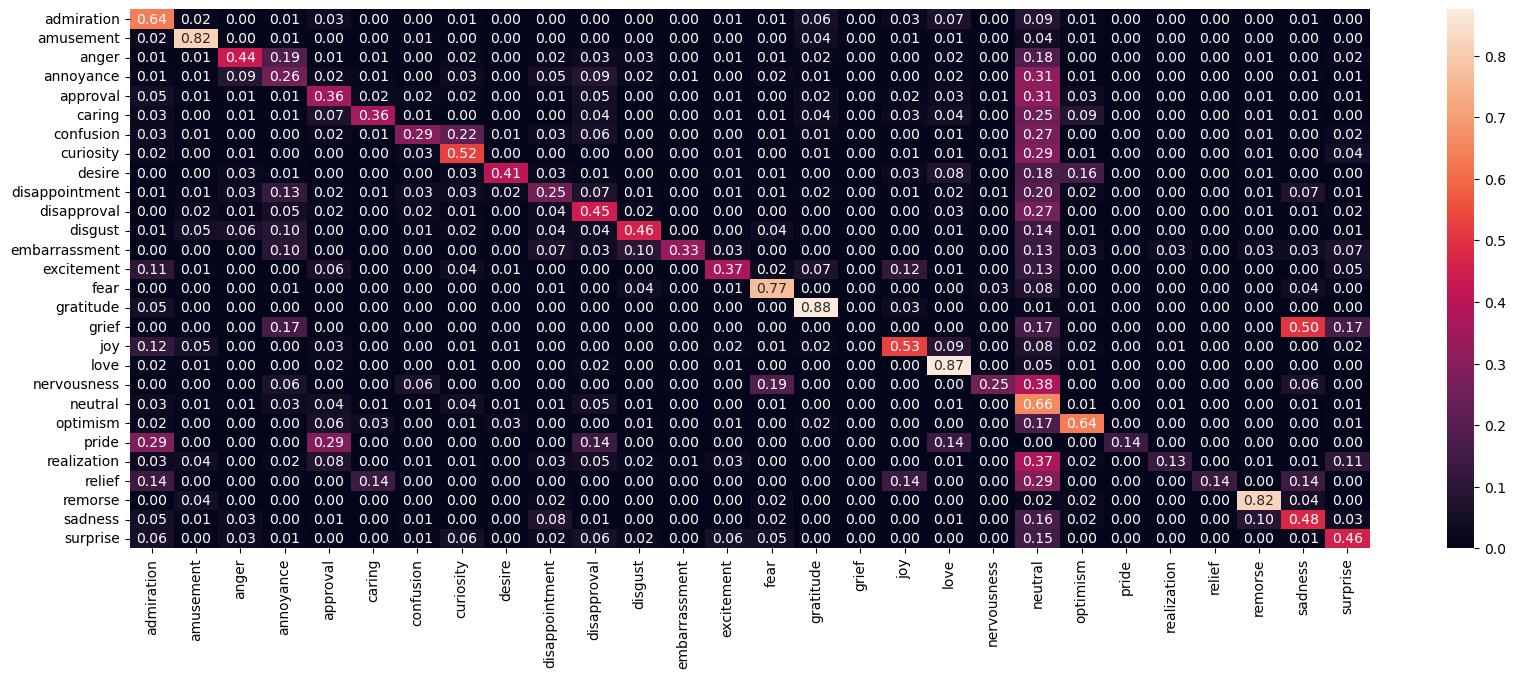

In [81]:
cm = confusion_matrix(np.argmax(processed["test"]["labels"], axis=1), np.argmax(test_pred, axis=1))
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    pd.DataFrame(cm, columns=target_names, index=target_names),
    annot=True,
    fmt="1.2f"
)

---